# Imports & Installs

In [ ]:
# !pip install vaderSentiment

In [ ]:
# Basic Python Libraries
import pandas as pd
import json
import numpy as np
import string
from collections import Counter
from google.colab import files
import gdown
from time import time
import os
import zipfile

import warnings
# Ignore PerformanceWarning
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# NLP and Text Processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from textblob import TextBlob
import spacy
from better_profanity import profanity

# Treads to speed-up processing
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

# Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from multiprocessing import cpu_count
cores = cpu_count()

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning and Text Analysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import joblib
from transformers import pipeline

# Downloads and Setup for NLTK and spaCy
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# load the Dataset

In [ ]:
# File ID extracted from the URL
file_id = '1qh0uqcFlF_mKZ6aav1aRHovJ_ArChAF2'

# URL for downloading directly
url = 'https://drive.google.com/uc?id=' + file_id

# Download the file
output = 'reddit_opinion_PSE_ISR.csv'
gdown.download(url, output, quiet=False)

tweets_df = pd.read_csv(output)
tweets_df = tweets_df.sample(frac=0.5, random_state=42) # Cut DS to increase data process time
tweets_df.reset_index(drop=True, inplace=True)
print(tweets_df.columns)
tweets_df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1qh0uqcFlF_mKZ6aav1aRHovJ_ArChAF2
From (redirected): https://drive.google.com/uc?id=1qh0uqcFlF_mKZ6aav1aRHovJ_ArChAF2&confirm=t&uuid=ce835dc7-d7d9-4b9c-925a-a153efc5c33d
To: /content/reddit_opinion_PSE_ISR.csv
100%|██████████| 2.02G/2.02G [00:32<00:00, 62.2MB/s]
<ipython-input-3-25380c9ab92d>:11: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv(output)


Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time'],
      dtype='object')


,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,l0rkpwq,191,I don’t like this guy,PublicFreakout,2024-04-22 16:55:15,1cacvga,BeeXman93,0,191,0,...,176.0,5905.0,6227.0,4041,NaN,Zionist Professor publicly freaking out after ...,0.81,4041,0,2024-04-22 14:54:56
1,k6pc2ex,26,"I joined army cadets at 11 in the UK, though a...",NonCredibleDefense,2023-10-27 16:52:23,17hlnjd,Articulated,0,26,0,...,24977.0,179327.0,207382.0,2554,NaN,"Wake up babes, there’s a new Hamas education c...",0.98,2554,0,2023-10-27 11:42:44
2,l3kz2b7,3,"It’s not exactly a secret, feel free to type t...",worldnewsvideo,2024-05-11 15:01:01,1cp1jre,PIuto,0,3,0,...,3416.0,15840.0,19374.0,956,NaN,“When a country behaves in a way that is not a...,0.93,956,0,2024-05-10 22:03:47
3,l0usb6i,1,"No, it isnt.",PublicFreakout,2024-04-23 06:36:39,1ca1fkr,bilbertbobert,0,1,0,...,1.0,1749.0,1750.0,528,NaN,Men driving by Pro-Palestine protestors spit a...,0.78,528,0,2024-04-22 04:06:55
4,kfxuvph,2,Reactive armor. The warheads they are using c...,Palestine,2024-01-02 05:18:58,18w1g6g,Donnarhahn,0,2,0,...,12128.0,37128.0,49491.0,1107,NaN,New footage for the resistance hitting IOF in ...,0.96,1107,0,2024-01-01 17:22:47


# Initial Data Process

## Data cleaning

In [ ]:
# Initialize the lemmatizer and sentiment analyzer
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()
ILLEGAL_CHARACTERS_RE = re.compile(r'[\000-\010]|[\013-\014]|[\016-\037]')


# Function to filter ill-formatted comments
def is_well_formatted(text):
    # Check if the text is a string and not empty or None
    if not isinstance(text, str) or not text:
        return False

    # Remove comments that are too short and non informative (ampiric)
    if len(text) < 50:
        return False

    if bool(ILLEGAL_CHARACTERS_RE.search(text)):
      return False

    # Remove deleted comments
    if 'Your content has been removed' in text:
      return False

    # Calculate the number of alphabetic characters
    alphabetic_chars = len(re.findall(r'[a-zA-Z]', text))

    # Calculate the total number of characters
    total_chars = len(text)

    # Calculate the proportion of alphabetic characters
    alphabetic_ratio = alphabetic_chars / total_chars

    # Check if the proportion is greater than 70%
    if alphabetic_ratio < 0.7:
        return False

    return True

# Filter out ill-formatted comments (too many non words)
tweets_df = tweets_df[tweets_df['self_text'].apply(is_well_formatted)]

# Remove uninformative columns - post content is not analyzad.
columns_to_remove = ['author_name', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text',
       'post_total_awards_received','post_id', 'post_thumbs_ups',
       'post_created_time', 'post_upvote_ratio', 'post_title', 'ups',	'downs']

# Allign column name formats
rename_dict = {
    'subreddit': 'Sub_Reddit',
    'self_text': 'Comment_Content',
    'comment_id': 'Comment_ID',
    'score': 'Score',
    'created_time': 'Date',
    'controversiality': 'Controversiality',
    'user_is_verified': 'Verified_User',
    'user_account_created_time': 'User_Account_Created_Time'
}

tweets_df.rename(columns=rename_dict, inplace=True)
tweets_df.drop(columns=columns_to_remove, inplace=True)

<ipython-input-4-3e1783081334>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df.rename(columns=rename_dict, inplace=True)
<ipython-input-4-3e1783081334>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df.drop(columns=columns_to_remove, inplace=True)


In [ ]:
def summarize_dataframe(df):
    summary = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            summary[column] = {
                'type': 'numeric',
                'min': df[column].min(),
                'max': df[column].max(),
                'mean': df[column].mean(),
                'n_nulls': df[column].isnull().sum(),
                'n_unique': df[column].nunique()
            }
        elif pd.api.types.is_bool_dtype(df[column]):
            summary[column] = {
                'type': 'binary',
                'min': df[column].min(),
                'max': df[column].max(),
                'mean': df[column].mean(),
                'n_nulls': df[column].isnull().sum(),
                'n_unique': df[column].nunique()
            }
        else:
            summary[column] = {
                'type': 'categorical',
                'n_unique': df[column].nunique(),
                'n_nulls': df[column].isnull().sum(),
                'categories': df[column].value_counts().to_dict()
            }
    return pd.DataFrame(summary).transpose()

# Usage
summary_df = summarize_dataframe(tweets_df)
summary_df

,type,n_unique,n_nulls,categories,min,max,mean
Comment_ID,categorical,556381,0,"{'k6pc2ex': 1, 'kpyizia': 1, 'kdvni8i': 1, 'ka...",NaN,NaN,NaN
Score,numeric,2312,0,NaN,-976,13322,22.292866
Comment_Content,categorical,554414,0,{'Your account was detected as a ban evading a...,NaN,NaN,NaN
Sub_Reddit,categorical,14,0,"{'IsraelPalestine': 207300, 'worldnews': 13053...",NaN,NaN,NaN
Date,categorical,545603,0,"{'2023-12-03 21:53:47': 4, '2023-11-13 20:29:4...",NaN,NaN,NaN
Controversiality,numeric,2,0,NaN,0,1,0.069715
Verified_User,categorical,2,0,"{True: 535726, False: 20655}",NaN,NaN,NaN
User_Account_Created_Time,categorical,121254,20342,"{'2020-05-15 11:39:40': 1626, '2023-08-29 20:3...",NaN,NaN,NaN


## Classify Pro-Palestine & Pro-Israel Comments

In [ ]:
# Function to preprocess the text
def preprocess_text(text):
    lemmatizer = nltk.WordNetLemmatizer()
    words = nltk.word_tokenize(text.lower())
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# Function to train the model
def train_model(file_path, kernel='linear', **kwargs):
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Filter out rows without labels
    df = df.dropna(subset=['Label'])

    # Preprocess the comments
    df['Processed_Comment'] = df['CommentContent'].apply(preprocess_text)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df['Processed_Comment'], df['Label'], test_size=0.2, random_state=42)

    # Create a pipeline with TF-IDF vectorizer and SVM classifier
    pipeline = make_pipeline(TfidfVectorizer(), SVC(kernel=kernel, probability=True, **kwargs))

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = pipeline.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred))

    # Train the model on the entire dataset
    pipeline.fit(df['Processed_Comment'], df['Label'])

    # Save the final model
    joblib.dump(pipeline, 'Affiliation_SVM.pkl')

    return pipeline

# Function to predict the affiliation of a single comment using the trained model
def predict_affiliation(comment, model):
    # Preprocess the comment
    processed_comment = preprocess_text(comment)

    # Predict the affiliation and probabilities
    affiliation = model.predict([processed_comment])[0]
    proba = model.predict_proba([processed_comment])[0]

    # Initialize the scores with zeros
    pro_israel_score = 0.0
    pro_palestine_score = 0.0

    # Check if 'pro-israel' and 'pro-palestine' classes are present in the model's classes
    if 'Pro-Israel' in model.classes_:
        pro_israel_score = proba[model.classes_ == 'Pro-Israel'][0]
    if 'Pro-Palestine' in model.classes_:
        pro_palestine_score = proba[model.classes_ == 'Pro-Palestine'][0]

    # Determine if the comment is certain based on the score threshold
    is_certain = ((pro_israel_score > 0.75) or (pro_palestine_score > 0.75)) and \
                 ((pro_israel_score > 2 * pro_palestine_score) or (pro_palestine_score > 2 * pro_israel_score))

    return {
        'Affiliation': affiliation,
        'Pro_Israel_Score': pro_israel_score,
        'Pro_Palestine_Score': pro_palestine_score,
        'Is_Certain': is_certain
    }

### Find Best Model

In [ ]:
# Example usage
file_path = '/content/Train File.xlsx'

# Attempt different kernels, pick best model

# Linear kernel
print('Linear kernel')
trained_model_linear = train_model(file_path, kernel='linear')

# Polynomial kernel
print('Polynomial kernel')
trained_model_poly = train_model(file_path, kernel='poly', degree=3)

# RBF kernel
print('RBF kernel')
trained_model_rbf = train_model(file_path, kernel='rbf', gamma='scale')

# Sigmoid kernel
print('Sigmoid kernel')
trained_model_sigmoid = train_model(file_path, kernel='sigmoid')

Linear kernel


FileNotFoundError: [Errno 2] No such file or directory: '/content/Train File.xlsx'

### POC on Picked Model

In [ ]:
# Example: Predict affiliation for a range of comments
file_path = '/content/Train File.xlsx'
train = pd.read_excel(file_path)
trained_model = train_model(file_path, kernel='linear')

for index, row in train[100:110].iterrows():
    comment = row['CommentContent']
    pred = predict_affiliation(comment, trained_model)
    if pred['Is_Certain']:
        print(f"Comment: {row['CommentContent']}")
        print(pred)

               precision    recall  f1-score   support

   Pro-Israel       0.96      0.71      0.82       137
Pro-Palestine       0.97      1.00      0.98      1184

     accuracy                           0.97      1321
    macro avg       0.96      0.85      0.90      1321
 weighted avg       0.97      0.97      0.96      1321

Comment: Judaism isn’t exactly peaceful either.  There’s been a few interesting interactions I’ve had with Jewish people.  One was a rabbi and his wife and another Jewish family during a cooking class in Thailand.  Everything had to be kosher until it was free.  Kind of wild in my opinion.  Another was over hearing a Jewish mom tell her child that they were the “chosen people” and they were better than everyone.  I mean, just wow.  Self proclaimed chosen people.  How convenient.  And look at Al the Jews in huge sex trafficking crimes like Epstein and ghislaine Maxwell. Harvey Weinstein.  Marv Albert.  Muslims and Jews aren’t that different.  In the last 76 ye

In [ ]:
# Function to analyze comments in parallel and add results to the DataFrame
def analyze_comments(df, model, text_col='Comment_Content', max_workers=10):
    results = []
    indices = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(predict_affiliation, text, model): index for index, text in df[text_col].items()}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing comments"):
            result = future.result()
            results.append(result)
            indices.append(futures[future])

    # Create DataFrame for results with proper indices
    results_df = pd.DataFrame(results, index=indices)

    # Concatenate the results with the original DataFrame using the correct indices
    df = pd.concat([df, results_df], axis=1)

    # Filter out uncertain predictions
    df_filtered = df[df['Is_Certain']]

    return df_filtered

### Test Model

In [ ]:
# Test Function Execution
test = analyze_comments(tweets_df.head(2000), trained_model)
i = 0
for index, row in test.iterrows():
    text = row['Comment_Content']
    pred = predict_affiliation(text, trained_model)
    if pred['Affiliation'] != row['Affiliation']:
        comment_id = row['Comment_ID']
        i += 1
        print(f'issue in row {comment_id}')

Processing comments: 100%|██████████| 2000/2000 [00:15<00:00, 128.15it/s]


In [ ]:
test.head()

,comment_id,score,CommentContent,SubReddit,created_time,post_id,controversiality,upvotes,downvotes,user_is_verified,user_account_created_time,post_title,post_upvote_ratio,post_thumbs_ups,Affiliation,Pro_Israel_Score,Pro_Palestine_Score,Is_Certain
0,l5rfw3d,1,The real ceasefire was the one we made along t...,worldnews,2024-05-26 16:19:40,1d11feu,0,1,0,True,2013-04-27 00:52:11,Hamas armed wing says it launched 'big missile...,0.93,1056,Pro-Palestine,0.032244,0.967756,True
3,l5rfum9,1,Did Ukranians actually get any significant amm...,CombatFootage,2024-05-26 16:19:25,1d12143,0,1,0,True,2023-01-02 14:29:58,The destruction of the Russian assault columns...,0.93,85,Pro-Palestine,0.195529,0.804471,True
4,l5rfuao,1,"My guess is mines, for why they are driving in...",CombatFootage,2024-05-26 16:19:22,1d12143,0,1,0,True,2015-05-08 12:12:57,The destruction of the Russian assault columns...,0.93,85,Pro-Palestine,0.038621,0.961379,True
5,l5rfu2p,1,Part two is declared war on France and ceising...,worldnews,2024-05-26 16:19:19,1d13nak,0,1,0,True,2020-06-15 16:30:31,British Conservatives plan to bring back manda...,0.77,14,Pro-Palestine,0.316878,0.683122,True
6,l5rfs6z,1,This land is your land. This land is my land...,worldnewsvideo,2024-05-26 16:19:00,1d0fy9u,0,1,0,True,2017-10-26 23:45:36,Settlers walk in with iron bars and steal a Pa...,0.97,358,Pro-Palestine,0.008588,0.991412,True


### Execute

In [ ]:
sampled_df = analyze_comments(tweets_df, trained_model)
sampled_df.head()

Processing comments: 100%|██████████| 556381/556381 [1:21:40<00:00, 113.55it/s]


,Comment_ID,Score,Comment_Content,Sub_Reddit,Date,Controversiality,Verified_User,User_Account_Created_Time,Affiliation,Pro_Israel_Score,Pro_Palestine_Score,Is_Certain
1,k6pc2ex,26,"I joined army cadets at 11 in the UK, though a...",NonCredibleDefense,2023-10-27 16:52:23,0,True,2013-05-06 08:39:26,Pro-Palestine,0.100497,0.899503,True
2,l3kz2b7,3,"It’s not exactly a secret, feel free to type t...",worldnewsvideo,2024-05-11 15:01:01,0,True,2011-12-11 20:46:02,Pro-Palestine,0.006310,0.993690,True
4,kfxuvph,2,Reactive armor. The warheads they are using c...,Palestine,2024-01-02 05:18:58,0,True,2013-07-04 00:42:17,Pro-Palestine,0.091321,0.908679,True
5,kzym4ku,16,We'll see the exact same argument if / when th...,worldnews,2024-04-17 09:12:16,0,True,2017-10-26 08:31:31,Pro-Palestine,0.109000,0.891000,True
6,l29edl7,1,There is a strong current in Israel of looking...,IsraelPalestine,2024-05-02 15:54:59,0,True,2014-07-29 23:48:40,Pro-Palestine,0.108935,0.891065,True


## Old Algorithm

In [ ]:
# israel_entities = ['israel', 'israeli', 'jew', 'jewish', 'jews', 'idf', 'iof', 'knesset', 'netanyahu',
#                    'gvir', 'settlement', 'settler', 'zion', 'zionist', 'isreal', 'hasbara',
#                    'isnotreal', 'biden', 'usa', 'united']  # And supporters
# palestine_entities = ['palestine', 'palestinian', 'palestinians', 'gaza', 'gazan', 'arab',
#                       'west bank', 'west-bank', 'hamas', 'haniya', 'rafah', 'khan', 'egypt', 'putin', 'china',
#                       'iran', 'jihad']  # And supporters

# # Lemmatize keywords
# israel_entities_lemma = [lemmatizer.lemmatize(word) for word in israel_entities]
# palestine_entities_lemma = [lemmatizer.lemmatize(word) for word in palestine_entities]


# def process_comment(text):
#     def generate_ngrams(words, n):
#       return zip(*[words[i:] for i in range(n)])
#     # Lemmatize the text and split into sentences
#     sentences = sent_tokenize(text)

#     israel_scores = []
#     palestine_scores = []

#     for sentence in sentences:
#         words = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(sentence)]

#         for n in range(3, 15):  # Generate n-grams from 3 to 7
#             ngrams = generate_ngrams(words, n)
#             for ngram in ngrams:
#                 ngram_text = ' '.join(ngram)
#                 ngram_sentiment = analyzer.polarity_scores(ngram_text)['compound']

#                 if any(entity in ngram for entity in israel_entities_lemma):
#                     israel_scores.append(ngram_sentiment)
#                     break  # Break to avoid counting the same n-gram in both groups

#                 if any(entity in ngram for entity in palestine_entities_lemma):
#                     palestine_scores.append(ngram_sentiment)
#                     break  # Break to avoid counting the same n-gram in both groups

#     # Calculate average sentiment scores
#     israel_sentiment = sum(israel_scores) / len(israel_scores) if israel_scores else 0
#     palestine_sentiment = sum(palestine_scores) / len(palestine_scores) if palestine_scores else 0

#     # Determine the overall sentiment
#     if israel_sentiment > palestine_sentiment:
#         sentiment = "pro-israel"
#     elif palestine_sentiment > israel_sentiment:
#         sentiment = "pro-palestine"
#     else:
#         sentiment = "disputed"

#     return israel_sentiment, palestine_sentiment, sentiment

# def analyze_comments(df, text_col='CommentContent', max_workers=10):
#     results = []
#     indices = []
#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         futures = {executor.submit(process_comment, text): index for index, text in df[text_col].items()}
#         for future in tqdm(as_completed(futures), total=len(futures), desc="Processing comments"):
#             result = future.result()
#             results.append(result)
#             indices.append(futures[future])

#     # Create DataFrame for results with proper indices
#     results_df = pd.DataFrame(results, columns=['Israel Sentiment', 'Palestine Sentiment', 'Affiliation'], index=indices)

#     # Concatenate the results with the original DataFrame using the correct indices
#     df = pd.concat([df, results_df], axis=1)

#     # Filter out disputed comments
#     df_filtered = df[df['Affiliation'] != 'disputed']

#     return df_filtered

In [ ]:
tweets_df

,comment_id,score,CommentContent,SubReddit,created_time,post_id,controversiality,upvotes,downvotes,user_is_verified,user_account_created_time,post_title,post_upvote_ratio,post_thumbs_ups
0,l5rfw3d,1,The real ceasefire was the one we made along t...,worldnews,2024-05-26 16:19:40,1d11feu,0,1,0,True,2013-04-27 00:52:11,Hamas armed wing says it launched 'big missile...,0.93,1056
3,l5rfum9,1,Did Ukranians actually get any significant amm...,CombatFootage,2024-05-26 16:19:25,1d12143,0,1,0,True,2023-01-02 14:29:58,The destruction of the Russian assault columns...,0.93,85
4,l5rfuao,1,"My guess is mines, for why they are driving in...",CombatFootage,2024-05-26 16:19:22,1d12143,0,1,0,True,2015-05-08 12:12:57,The destruction of the Russian assault columns...,0.93,85
5,l5rfu2p,1,Part two is declared war on France and ceising...,worldnews,2024-05-26 16:19:19,1d13nak,0,1,0,True,2020-06-15 16:30:31,British Conservatives plan to bring back manda...,0.77,14
6,l5rfs6z,1,This land is your land. This land is my land...,worldnewsvideo,2024-05-26 16:19:00,1d0fy9u,0,1,0,True,2017-10-26 23:45:36,Settlers walk in with iron bars and steal a Pa...,0.97,358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430310,jytpoft,10,Tbf there is a lot of anger and hatred in Isra...,ActualPublicFreakouts,2023-09-02 16:17:04,1680ip7,1,10,0,True,2017-09-03 20:40:14,Eritrean immigrants (illegals) fighting in the...,0.94,597
1430311,jytp2td,92,"Wait so these guys are rioting in: Israel, +Sw...",ActualPublicFreakouts,2023-09-02 16:13:20,1680ip7,0,92,0,True,2012-09-18 04:00:14,Eritrean immigrants (illegals) fighting in the...,0.94,597
1430316,jyt6xqn,62,They're doing it all over Europe at the moment...,ActualPublicFreakouts,2023-09-02 14:17:26,1680ip7,0,62,0,True,2022-10-29 14:00:07,Eritrean immigrants (illegals) fighting in the...,0.94,597
1430318,jyt10so,214,They should leave the anger and hatred back wh...,ActualPublicFreakouts,2023-09-02 13:33:15,1680ip7,0,214,0,True,2014-06-18 09:37:55,Eritrean immigrants (illegals) fighting in the...,0.94,597


In [ ]:
# Test
test = analyze_comments(tweets_df.head(2000))
i = 0
for index, row in test.iterrows():
    text = row['CommentContent']
    israel_sent, palestine_sent, decision = process_comment(text)
    if israel_sent != row['Israel Sentiment'] or palestine_sent != row['Palestine Sentiment']:
        comment_id = row['comment_id']
        i += 1
        print(f'issue in row {comment_id}')
print(i)

Processing comments: 100%|██████████| 2000/2000 [00:06<00:00, 293.05it/s]


0


In [ ]:
sampled_df = analyze_comments(tweets_df)

Processing comments: 100%|██████████| 1112630/1112630 [25:50<00:00, 717.81it/s] 


# Text Normalization

In [ ]:
# Download necessary NLTK data
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
_ = nltk.corpus.words.words()
_ = nltk.corpus.stopwords.words('english')
_ = nltk.corpus.wordnet.words()

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Spell corrector
spell = Speller(lang='en')

# Function to normalize text with additional steps
def remove_emoji(string):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)

def remove_hyperlinks(text):
    temp = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.',text)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('&gt;', "", temp) # greater than sign
    temp = re.sub('&#x27;', "'", temp) # apostrophe
    temp = re.sub('&#x2F;', ' ', temp)
    temp = re.sub('<p>', ' ', temp) # paragraph tag
    temp = re.sub('<i>', ' ', temp) #italics tag
    temp = re.sub('</i>', '', temp)
    temp = re.sub('&#62;', '', temp)
    temp = re.sub("\n", '', temp) # newline
    return temp

def spell_correct(text):
  # initial speller basic correction
  text = spell(text)

  # context dependent correction
  text = TextBlob(text).correct()
  return text


def clean_text(text, spell_correction = True):
    '''
    Clean the text to have only words useful for language.
    First step
    - no links / html / contractions
    - lower text
    - no characters not present in an english word
    - no non alphanumeric symbols
    - spell correction (optional)
    - remove stopwords
    '''
    # lower text
    text = text.lower()

    # Remove emoji's and hyperlinks
    text = remove_hyperlinks(text)
    text =  remove_emoji(text)

    # Remove URLs
    text = re.sub("'", "", text) # to avoid removing contractions in english
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    punc=string.punctuation
    text=text.translate(str.maketrans('','',punc))

    # Correct typos, keep only english words
    if spell_correction:
      text = spell_correct(text)

    # Remove stopwords & Lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in ENGLISH_STOP_WORDS])

    return text

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# # Get a subset of the data
# def sample_comments(df, text_col='CommentContent', sample_size=150000):
#     sampled_df = df.sample(n=min(len(df), sample_size), random_state=1).reset_index(drop=True)
#     return sampled_df

# # Apply sampling
# sampled_df_ = sample_comments(sampled_df)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm

# Function to process each row and update progress
def process_row(row, index, progress_bar):
    normalized_text = clean_text(row['Comment_Content'], spell_correction = False)  # Spell correction is very heavy
    progress_bar.update(1)
    return index, normalized_text


# Initialize progress bar
progress_bar = tqdm.tqdm(total=len(sampled_df), desc="Processing comments")

# Initialize a list to store futures
futures = []

# Use ThreadPoolExecutor to parallelize the processing
with ThreadPoolExecutor(max_workers=10) as executor:
    for index, row in sampled_df.iterrows():
        futures.append(executor.submit(process_row, row, index, progress_bar))

# Collect results
results = [future.result() for future in as_completed(futures)]

# Close the progress bar
progress_bar.close()

# Update the DataFrame with normalized tweets
for index, normalized_text in results:
    sampled_df.at[index, 'Normalized_English_Comment'] = normalized_text

# Remove rows with empty values in 'normalized_english_tweet' column
sampled_df = sampled_df[sampled_df['Normalized_English_Comment'] != '']

# Reset the index after removing rows
sampled_df.reset_index(drop=True, inplace=True)

# Save file
sampled_df.to_csv('semi_processed_.csv', index=False)
files.download('semi_processed_.csv')

Processing comments: 100%|██████████| 486435/486435 [14:14<00:00, 569.25it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # File ID extracted from the URL
# file_id = '1oNywMWfqNQbF2lvMqL63e5gSun5hbrOE'

# # URL for downloading directly
# url = 'https://drive.google.com/uc?id=' + file_id

# # Download the file
# output = 'semi_processed_.csv'
# gdown.download(url, output, quiet=False)

# Load the file
sampled_df = pd.read_csv('/content/semi_processed_.csv', on_bad_lines='skip')

<ipython-input-3-b5040c5bf4fa>:12: DtypeWarning: Columns (1,5,6,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  sampled_df = pd.read_csv('/content/semi_processed_.csv', on_bad_lines='skip')


Stats

In [ ]:
# Number of rows
num_rows = len(sampled_df)
print(f"Number of rows: {num_rows}")

# Print the counts
affiliation_counts = sampled_df['Affiliation'].value_counts()
print("Counts of unique values in the 'Affiliation' column:")
print(affiliation_counts)

# Basic info
print("Basic info:")
print(sampled_df.info())

# Descriptive statistics
print("Descriptive statistics:")
print(sampled_df.describe())

Number of rows: 512659
Counts of unique values in the 'Affiliation' column:
Affiliation
Pro-Palestine        473671
Pro-Israel            11069
0.857662311165243         1
Name: count, dtype: int64
Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512659 entries, 0 to 512658
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Comment_ID                  512659 non-null  object
 1   Score                       512659 non-null  object
 2   Comment_Content             512659 non-null  object
 3   Sub_Reddit                  484741 non-null  object
 4   Date                        484741 non-null  object
 5   Controversiality            484741 non-null  object
 6   Verified_User               484741 non-null  object
 7   User_Account_Created_Time   466853 non-null  object
 8   Affiliation                 484741 non-null  object
 9   Pro_Israel_Score            484741 non-null  ob

# Subject Identification

## Method

In [ ]:
# Initialize number of cores for training
cores = multiprocessing.cpu_count()

# Combine all sentences into a single list
sentences = sampled_df['Normalized_English_Comment'].tolist()

# Tokenize the sentences
sent = [word_tokenize(row) for row in sentences]

# Create bigrams and trigrams
bigram_phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(bigram_phrases)
sentences_bigrams = bigram[sent]

trigram_phrases = Phrases(sentences_bigrams, min_count=30, progress_per=10000)
trigram = Phraser(trigram_phrases)
sentences_trigrams = trigram[sentences_bigrams]

# Train Word2Vec model with a larger window size
w2v_model = Word2Vec(min_count=20, window=3, vector_size=100, sample=6e-5,
                     alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
w2v_model.build_vocab(sentences_trigrams, progress_per=10000)
w2v_model.train(sentences_trigrams, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

# Save the model
w2v_model.save("w2v_trigram.model")

def plot_w2v_clusters(model, num_words=100):
    # Extract word vectors
    words = list(model.wv.index_to_key)[:num_words]
    word_vectors = model.wv[words]

    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=300)
    word_vecs_2d = tsne.fit_transform(word_vectors)

    # Plot the word vectors
    plt.figure(figsize=(12, 8))
    plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], edgecolors='k', c='r')

    for word, (x, y) in zip(words, word_vecs_2d):
        plt.text(x, y, word, fontsize=12)

    plt.title('Word2Vec Clusters using t-SNE')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

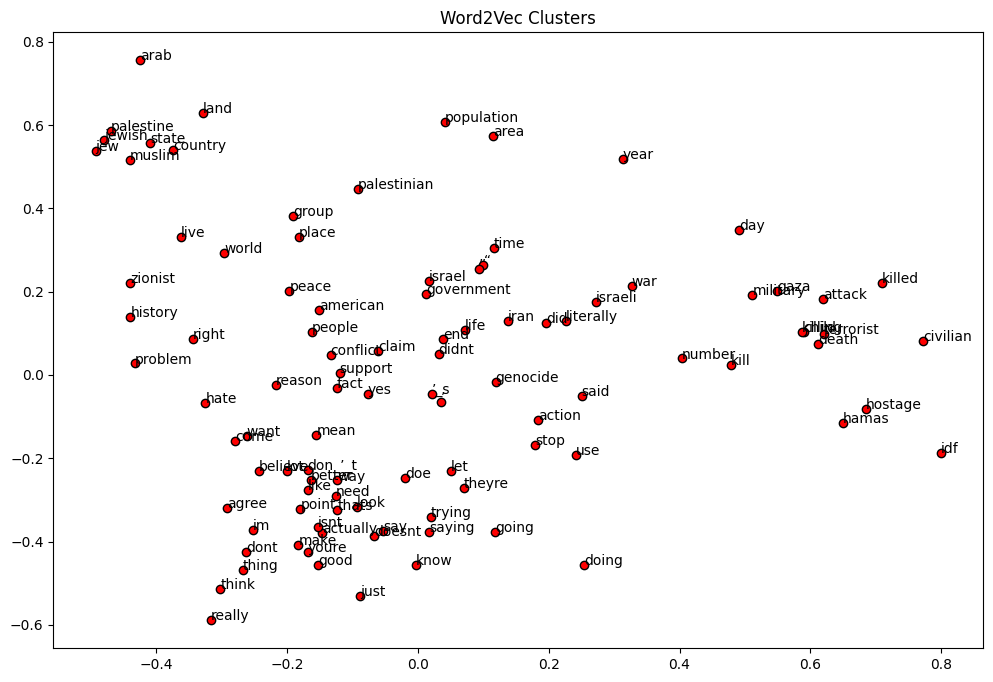

In [ ]:
# Plot the clusters
plot_w2v_clusters(w2v_model)

## Mapper

In [ ]:
# Prefix for relevant keywords to be looked for:
subtopics_keywords = {
    'Israel': ['israel', 'zio', 'jerusalem', 'tel aviv', 'tlv', 'knesset'],
    'judaism': ['jew', 'antisemit', 'anti-semit', 'anti semit', 'synagogue', 'rabbi'],
    'Islam': ['islam', 'jihad', 'muslim', 'mosque', 'sharia', 'imam', 'allah'],
    'Palestine': ['pa ', 'plo', 'palestine', 'gaza', 'west bank', 'palestinian', 'pali', 'river', 'sea', 'rafah', 'khan', 'west-bank', 'abbas', 'arafat', 'shtayyeh', 'hamdallah'],
    'IDF': ['idf', 'iof', 'israel defence', 'israel-defence', 'iron dome', 'herzi', 'soldier', 'diaper force', 'diaper-force', 'merkava', 'troop', 'airforce', 'air force', 'air-force', 'tank', 'f-15', 'f-16'],
    'Hamas': ['hamas', 'resist', 'haniya', 'deif', 'sinwar', 'shahid'],
    'USA': ['u.s', 'usa', 'biden', 'united states', 'ny', 'new york', 'america', 'american', 'joe', 'republican', 'democrat', 'trump'],
    'UN': ['united nation', 'u.n', 'un ', 'unrwa', 'cij', 'icj', 'hague'],
    'Europe': ['eu', 'europe', 'england', 'ireland', 'spain', 'france', 'paris', 'sweden', 'uk', 'dublin', 'norw'],
    'Arab World / Supporters': ['arab', 'egypt', 'quatar', 'ue', 'lebanon', 'jordan', 'syria', 'turkey',
                                'iran', 'south africa', 'china', 'russia', 'uae', 'doha'],
    'Netanyahu': ['bibi', 'netanyahu', 'satanyahu'],
    'Universities': ['columbia', 'cornell', 'harvard', 'penn', 'princeton', 'yale', 'student', 'professor', 'ivy',
                 'universit', 'ut', 'usc', 'mit', 'berkeley', 'nyu', 'colleg'],
    'Hostages': ['hostage', 'kidnapp', 'bring them home', 'bibas', 'argamani', 'release'],
    'Peace': ['deal', 'peace','negotiation', 'cease'],
    'War': ['war', 'conflict', 'genocide', 'kill', 'attack', 'death', 'riot', 'bomb', 'rocket', 'martyr', 'human shield', 'tunnel', 'massacre', 'destroy', 'occup', 'murder']

}

# Features Addition

In [ ]:
# continue from here
w2v_model = Word2Vec.load("/content/w2v_trigram.model")

In [ ]:
# Fact Speaking VS Belief Speaking
fact_speaking_words = [
'actually',
'analyze',
'assess',
'correct',
'correction',
'determine',
'evaluate',
'evidence',
'examine',
'exploration',
'fact',
'information',
'inspect',
'investigate',
'proof',
'prove',
'question',
'quiz',
'real',
'reality',
'rectify',
'research',
'revise',
'sample',
'science',
'scrutinize',
'search',
'specify',
'supervise',
'test',
'trace',
'track',
'trial',
'truth',
'validate',
'verify',
'observe']


belief_speaking_words = [
'basically',
'believe',
'confide',
'consider',
'envisage',
'feel',
'frankly',
'guess',
'obvious',
'obviously',
'of course',
'opinion',
'plainly',
'position',
'presume',
'probably',
'seem',
'sensation',
'sentiment',
'suggestion',
'suppose',
'surely',
'think',
'trust',
'view',
'claim',
'contemplate',
'contention',
'genuinely',
'hint',
'judge',
'look',
'ponder',
'signal',
'suggest',
'try',
'virtually']


def get_embedding_vector(tokens, model):
    # Average word vectors for the tokens
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return [0] * model.vector_size
    return np.mean(vectors, axis=0)

fact_vector = get_embedding_vector(fact_speaking_words, w2v_model)
belief_vector = get_embedding_vector(belief_speaking_words, w2v_model)

def classify_comment(comment, norm_comment, model, fact_vector, belief_vector):
    '''
    Using a W2V approach, find the similarity between the comment and the fact and belief vectors.
    Use TextBlob subjectivity score to weight the similarity. Will use the normalized comment.

    Subjectivity measures the amount of personal opinion and factual information contained in the text.
    Range from [0,1]. Will use the original comment.
    '''
    # Tokenize and vectorize the comment
    tokens = word_tokenize(norm_comment)
    comment_vector = get_embedding_vector(tokens, model)
    subjectivity = TextBlob(comment).sentiment.subjectivity

    # Compute cosine similarities, normalize to range [0,1]
    fact_similarity = (cosine_similarity([comment_vector], [fact_vector])[0][0] + 1)/2
    belief_similarity = (cosine_similarity([comment_vector], [belief_vector])[0][0] +1)/2

    weighted_fact_similarity = fact_similarity * (1 - subjectivity)
    weighted_belief_similarity = belief_similarity * subjectivity

    # Classify based on the higher similarity score
    return weighted_fact_similarity,  weighted_belief_similarity

In [ ]:
def find_subtopics(text):
  '''
  Run on Original + Normalized text
  '''
  subtopics = set()
  for subtopic, keywords in subtopics_keywords.items():
      if any(keyword in text for keyword in keywords):
          subtopics.add(subtopic)
  return subtopics

def word_count(text):
  '''
  Run on Normalized text
  '''
  return len(text.split())


analyzer = SentimentIntensityAnalyzer()
def calculate_polarity_sentiment(text):
  '''
  Run on Original text
  '''
  scores = analyzer.polarity_scores(text)
  return scores['compound']



# Load a pre-trained model for text classification and bad words identification
toxicity_classifier = pipeline("text-classification", model="unitary/toxic-bert")
profanity.load_censor_words()


def assess_toxicity(comment):
  '''
  Calculates the avg toxicity score for a comment by breaking it to sentences and calculating the toxicity score for each sentence.
  Uses pre-trained toxic-bert model.
  Return the toxicity score and words (if exists) else Nulled.
  '''
  # Initialize variables to store toxicity scores and toxic words
  toxicity_scores = []
  toxic_words = []

  # Get toxic words from whole comment:
  words = word_tokenize(comment)
  toxic_words.extend([word for word in words if profanity.contains_profanity(word)])
  # Calculate the toxicity score for each sentence and extract toxic words
  # Break the comment into sentences
  sentences = [sentence for sentence in sent_tokenize(comment) if len(sentence) < 512]
  # Batch process the sentences
  if sentences:
      results = toxicity_classifier(sentences)
      toxicity_scores = [result['score'] for result in results]

  # Calculate the average toxicity score
  avg_toxicity = sum(toxicity_scores) / len(toxicity_scores) if toxicity_scores else 0
  return avg_toxicity, toxic_words if toxic_words else None


# def call_for_action_score(text):
#     """
#     Calculate a call for action score for each tweet based on the relative frequency
#     of specific parts of speech that indicate passion or a call to action.

#     Parameters:
#     df (pandas.DataFrame): DataFrame containing the tweets data with a column 'normalized_english_tweet'.

#     Returns:
#     pandas.DataFrame: DataFrame with an additional column 'CallForActionScore' indicating the calculated score.
#     """
#     doc = nlp(text)
#     pos_counts = doc.count_by(spacy.attrs.POS)
#     pos_dict = {nlp.vocab.strings[k]: v for k, v in pos_counts.items()}

#     # Relevant POS tags for call to action and passion
#     verbs = pos_dict.get('VERB', 0) * 1.5  # Higher weight to verbs
#     adjectives = pos_dict.get('ADJ', 0)
#     adverbs = pos_dict.get('ADV', 0)
#     interjections = pos_dict.get('INTJ', 0)

#     # Calculate the score based on the sum of these POS tags relative to the total word count
#     total_words = sum(pos_dict.values())
#     if total_words == 0:
#         return 0

#     # Calculate base POS score
#     score = (verbs + adjectives + adverbs + interjections) / total_words

#     # Add additional factors
#     additional_score = 0
#     additional_score += text.count('!') * 0.2
#     additional_score += text.count('?') * 0.2
#     additional_score += text.lower().count('need') * 0.5
#     additional_score += text.lower().count('must') * 0.5
#     additional_score += text.lower().count('act') * 0.5
#     additional_score += text.lower().count('now') * 0.5
#     additional_score += text.lower().count('immediate') * 0.5
#     additional_score += text.lower().count('urgent') * 0.5
#     additional_score += sum(1 for word in text.split() if word.isupper() and word.lower() not in ENGLISH_STOP_WORDS) * 0.3

#     # Combine base score with additional factors
#     score += additional_score

#     # Calculate Word2Vec similarity with specific action words
#     action_words = ["act", "urgent", "immediate", "now", "must", "need"]
#     action_vectors = [w2v_model.wv[word] for word in action_words if word in w2v_model.wv]

#     if action_vectors:
#         text_vector = np.mean([w2v_model.wv[word] for word in text.split() if word in w2v_model.wv], axis=0)
#         if text_vector.size > 0:  # Ensure text_vector is not empty
#             similarity_score = np.mean([np.dot(text_vector, action_vector) for action_vector in action_vectors])
#             score += similarity_score * 0.1  # Adjust weight as needed

#     return score

In [ ]:
def process_row(row):
    original_text = row['Comment_Content']
    normalized_text = row['Normalized_English_Comment']

    subtopics_original = find_subtopics(original_text)
    subtopics_normalized = find_subtopics(normalized_text)
    subtopics = find_subtopics(original_text) | find_subtopics(normalized_text)
    subtopics = subtopics if subtopics else None

    word_cnt = word_count(normalized_text)
    polarity = calculate_polarity_sentiment(original_text)
    # call_to_action = call_for_action_score(normalized_text)
    fact_similarity, belief_similarity = classify_comment(original_text, normalized_text, w2v_model, fact_vector, belief_vector)
    # toxicity_score, toxic_words = assess_toxicity(original_text)
    return subtopics, word_cnt, polarity, fact_similarity, belief_similarity

def AddFeatures(df, max_workers=10, save_interval=10000, file_prefix="processed_data"):
    print("Adding features...")
    results = []
    df = df.dropna(subset=['Comment_Content', 'Normalized_English_Comment'])

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_row, row): idx for idx, row in df.iterrows()}
        total = len(futures)
        for count, future in enumerate(futures, 1):
            idx = futures[future]
            subtopics, word_cnt, polarity, fact_similarity, belief_similarity = future.result()
            df.loc[idx, 'Sub_Topics'] = str(subtopics)
            df.loc[idx, 'Word_Count'] = word_cnt
            df.loc[idx, 'Polarity_Sentiment'] = polarity
            df.loc[idx, 'Fact_Similarity'] = fact_similarity
            df.loc[idx, 'Belief_Similarity'] = belief_similarity
            # df.loc[idx, 'Toxicity_Score'] = toxicity_score
            # df.loc[idx, 'Toxic_Words'] = toxic_words
            if count % save_interval == 0 or count == total:
                print(f"Processed {count}/{total} rows")
                # file_name = f"{file_prefix}_partial.csv"
                # df.to_csv(file_name, index=False)
                # files.download(file_name)

    return df

In [ ]:
try:
    sampled_df.drop('Unnamed: 0', axis=1, inplace=True)
except:
    pass
sampled_df.head()

,Comment_ID,Score,Comment_Content,Sub_Reddit,Date,Controversiality,Verified_User,User_Account_Created_Time,Affiliation,Pro_Israel_Score,Pro_Palestine_Score,Is_Certain,Normalized_English_Comment
0,k6pc2ex,26,"I joined army cadets at 11 in the UK, though a...",NonCredibleDefense,2023-10-27 16:52:23,0,True,2013-05-06 08:39:26,Pro-Palestine,0.100497,0.899503,True,joined army cadet 11 uk admittedly didnt fat a...
1,l3kz2b7,3,"It’s not exactly a secret, feel free to type t...",worldnewsvideo,2024-05-11 15:01:01,0,True,2011-12-11 20:46:02,Pro-Palestine,0.00631,0.99369,True,’ s exactly secret feel free type company ’ s ...
2,kfxuvph,2,Reactive armor. The warheads they are using c...,Palestine,2024-01-02 05:18:58,0,True,2013-07-04 00:42:17,Pro-Palestine,0.091321,0.908679,True,reactive armor warhead using penetrate armor
3,kzym4ku,16,We'll see the exact same argument if / when th...,worldnews,2024-04-17 09:12:16,0,True,2017-10-26 08:31:31,Pro-Palestine,0.109,0.891,True,exact argument baltic state attacked whats mil...
4,l29edl7,1,There is a strong current in Israel of looking...,IsraelPalestine,2024-05-02 15:54:59,0,True,2014-07-29 23:48:40,Pro-Palestine,0.108935,0.891065,True,strong current israel looking diaspora far ash...


In [ ]:
column_order = ['Comment_ID', 'Sub_Reddit', 'Sub_Topics', 'Comment_Content', 'Normalized_English_Comment', 'Date', 'User_Account_Created_Time',
                'Verified_User', 'Word_Count', 'Controversiality', 'Score', 'Pro_Israel_Score',	'Pro_Palestine_Score',
                'Affiliation', 'Fact_Similarity', 'Belief_Similarity', 'Polarity_Sentiment', 'Toxicity_Score', 'Toxic_Words']

sampled_df = sampled_df.dropna(how='any')
sampled_df = AddFeatures(sampled_df)

column_order = [column for column in column_order if column in sampled_df.columns]
sampled_df = sampled_df[column_order]
sampled_df = sampled_df.dropna(how='any')
sampled_df.to_csv('Preprocessed_Dataset.csv', index=False)
files.download('Preprocessed_Dataset.csv')

Adding features...
Processed 10000/466852 rows
Processed 20000/466852 rows
Processed 30000/466852 rows
Processed 40000/466852 rows
Processed 50000/466852 rows
Processed 60000/466852 rows
Processed 70000/466852 rows
Processed 80000/466852 rows
Processed 90000/466852 rows
Processed 100000/466852 rows
Processed 110000/466852 rows
Processed 120000/466852 rows
Processed 130000/466852 rows
Processed 140000/466852 rows
Processed 150000/466852 rows
Processed 160000/466852 rows
Processed 170000/466852 rows
Processed 180000/466852 rows
Processed 190000/466852 rows
Processed 200000/466852 rows
Processed 210000/466852 rows
Processed 220000/466852 rows
Processed 230000/466852 rows
Processed 240000/466852 rows
Processed 250000/466852 rows
Processed 260000/466852 rows
Processed 270000/466852 rows
Processed 280000/466852 rows
Processed 290000/466852 rows
Processed 300000/466852 rows
Processed 310000/466852 rows
Processed 320000/466852 rows
Processed 330000/466852 rows
Processed 340000/466852 rows
Proc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If processed file is too big for the computer memory - zip

In [ ]:
# Print the size of the DataFrame, number of rows, and columns
print(f'Number of rows: {sampled_df.shape[0]}')
print(f'Number of columns: {sampled_df.shape[1]}')

# Save the DataFrame to a CSV file
csv_filename = 'Preprocessed_Dataset.csv'
sampled_df.to_csv(csv_filename, index=False)

# Get the size of the CSV file
csv_file_size = os.path.getsize(csv_filename) / (1024 * 1024)  # Size in MB
print(f'Size of CSV file: {csv_file_size:.2f} MB')

# Compress the CSV file into a ZIP file
zip_filename = 'Preprocessed_Dataset.zip'
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_filename)

# Get the size of the ZIP file
zip_file_size = os.path.getsize(zip_filename) / (1024 * 1024)  # Size in MB
print(f'Size of ZIP file: {zip_file_size:.2f} MB')

# Download the ZIP file
files.download(zip_filename)

# Test Stuff

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine the toxic words into a single string
toxic_text = " ".join(toxic_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()